# Imports, setup, etc.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rcParams.update({
    'font.size': 12,
    "text.usetex": True,
    "font.family": "serif"
})

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_57301/3744927176.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [2]:
# TAKING kinetic schemes from Crampin 2002 Sec. 2.5
class KineticScheme:
    def __init__(self, params):
        self.params = params
    
    def reaction(self, u, v, xi, t):
        raise NotImplementedError("Subclasses should implement this!")

class Schnakenberg(KineticScheme):
    def reaction(self, u, v, xi, t):
        a, b = self.params
        return b - u * (v**2), a + u * (v**2) - v

class GiererMeinhardt(KineticScheme):
    def reaction(self, u, v, xi, t):
        a, b = self.params
        return v**2 - u, (v**2) / u - a * v + b

In [3]:
class BaseGrowth:
    def __init__(self, rho=1):
        self.rho = rho

    def growth_fcn_r(self, t):
        raise NotImplementedError

    def strain_rate_S(self, xi, t):
        raise NotImplementedError

class ExponentialGrowth(BaseGrowth):
    def growth_fcn_r(self, t):
        return np.exp(self.rho * t)  # Exponential growth

    def strain_rate_S(self, xi, t):
        return self.rho

class LinearGrowth(BaseGrowth):
    def growth_fcn_r(self, t):
        return 1 + self.rho * t  # Linear growth

    def strain_rate_S(self, xi, t):
        return self.rho / (1 + self.rho * t)

class LogisticGrowth(BaseGrowth):
    def __init__(self, zeta, rho=1):
        super().__init__(rho)
        self.zeta = zeta  # Carrying capacity

    def growth_fcn_r(self, t):
        return np.exp(self.rho * t) / (1 + (1/self.zeta) * (np.exp(self.rho * t) - 1))

    def strain_rate_S(self, xi, t):
        return self.rho / (1 + np.exp(self.rho * t) / (self.zeta - 1))

class ApicalGrowth(BaseGrowth):
    def __init__(self, rho=1, delta=0.01):
        super().__init__(rho)
        self.delta = delta  # Width of the region with non-zero strain rate

    def growth_fcn_r(self, t):
        return 1 + self.rho * t

    # The below is needed for chi term in non-uniform growth models
    def dr_dt(self, t):
        return self.rho

    def strain_rate_S(self, xi, t):
        # Strain rate is 0 for xi in [0, 1 - delta) and rho/delta for xi in [1 - delta, 1]
        S = np.zeros_like(xi)  # Start with a zero array
        apical_region = xi >= (1 - self.delta)  # Boolean array for the apical region
        S[apical_region] = self.rho / self.delta  # Set the strain rate in the apical region
        return S

In [4]:
class ReactionDiffusionSolver:
    def __init__(self, kinetic_scheme, Du, Dv, gamma0, num_points, growth_type, rho, delta=None, zeta=None, length=1):
        self.kinetic_scheme = kinetic_scheme
        self.Du = Du
        self.Dv = Dv
        self.gamma0 = gamma0
        
        self.length = length
        self.num_points = num_points
        self.xi = np.linspace(0, length, self.num_points)
        self.dxi = self.xi[1] - self.xi[0] # infer spatial grid spacing

        
        # Select the growth type
        if growth_type == 'exp':
            self.growth_model = ExponentialGrowth(rho=rho)
        elif growth_type == 'linear':
            self.growth_model = LinearGrowth(rho=rho)
        elif growth_type == 'logistic':
            self.growth_model = LogisticGrowth(rho=rho, zeta=zeta)
        elif growth_type == 'apical':
            self.growth_model = ApicalGrowth(rho=rho, delta=delta)
        else:
            raise ValueError("Unsupported growth type")
    
    
    def growth_fcn_r(self, t):
        return self.growth_model.growth_fcn_r(t)
    
    def strain_rate_S(self, xi, t):
        return self.growth_model.strain_rate_S(xi, t)
    
    def pde_system(self, t, uv):
        u, v = uv.reshape(2, -1)
        # Initialise second derivative arrays with zeros
        d2u_dxi2 = np.zeros_like(u)
        d2v_dxi2 = np.zeros_like(v)

        # Interior points using central difference
        d2u_dxi2[1:-1] = (u[:-2] - 2 * u[1:-1] + u[2:]) / self.dxi**2
        d2v_dxi2[1:-1] = (v[:-2] - 2 * v[1:-1] + v[2:]) / self.dxi**2

        # Neumann BCs: Set the derivative at boundaries such that the flux is zero
        # This means the difference between the boundary and the ghost point should be zero
        # Second derivative at the boundaries
        d2u_dxi2[0]  = (u[1]  - 2 * u[0]  + u[1])  / self.dxi**2
        d2u_dxi2[-1] = (u[-2] - 2 * u[-1] + u[-2]) / self.dxi**2
        d2v_dxi2[0]  = (v[1]  - 2 * v[0]  + v[1])  / self.dxi**2
        d2v_dxi2[-1] = (v[-2] - 2 * v[-1] + v[-2]) / self.dxi**2

        # Reaction terms
        ru, rv = self.kinetic_scheme.reaction(u, v, self.xi, t)
        
        # Domain length
        r = self.growth_fcn_r(t)
        
        # Strain rate at each point. For dilution term
        strain_rates = self.strain_rate_S(self.xi, t)  
        
        # Below two lines are without domain growth. For comparison only
        # du_dt = self.Du * (1 / self.gamma0) * d2u_dxi2 + ru
        # dv_dt = self.Dv * (1 / self.gamma0) * d2v_dxi2 + rv

        # Build up "ODEs" from PDEs' RHS. For time integration.
        # Only non-uniform growth function for now is apical growth.
        # Consider simlified form of chi in the limit delta --> 0 (flow is zero everywhere).
        if isinstance(self.growth_model, ApicalGrowth):
            # In non-uniform growth case also need: first spatial derivative of morphogen concentrations;
            # time-derivative of domain length
            du_dxi = np.gradient(u, self.dxi, edge_order=2)
            dv_dxi = np.gradient(v, self.dxi, edge_order=2)
            dr_dt = self.growth_model.dr_dt(t)
            
            chi_u = (self.xi / r) * dr_dt
            chi_v = (self.xi / r) * dr_dt
            
            du_dt = self.Du * (1 / (self.gamma0 * r**2)) * d2u_dxi2 + chi_u * du_dxi - u * strain_rates + ru
            dv_dt = self.Dv * (1 / (self.gamma0 * r**2)) * d2v_dxi2 + chi_v * dv_dxi - v * strain_rates + rv
            
        # Else have the uniform case, with simpler RHS
        else:
            du_dt = self.Du * (1 / (self.gamma0 * r**2)) * d2u_dxi2 - u * strain_rates + ru
            dv_dt = self.Dv * (1 / (self.gamma0 * r**2)) * d2v_dxi2 - v * strain_rates + rv
        
        return np.concatenate([du_dt, dv_dt])
    
    # Note: BDF is also used, for example,
    # in Crampin, Gaffney, and Maini, Reaction and Diffusion on Growing Domains: Scenarios for Robust Pattern Formation, 1999
    def solve(self, u0, v0, t_span, t_eval, rtol=1e-4, atol=1e-6):
        uv0 = np.concatenate([u0, v0])
        sol = solve_ivp(self.pde_system, t_span, uv0, t_eval=t_eval, method='BDF', rtol=rtol, atol=atol)
        return sol

# Computing and plotting solutions

In [5]:
def solve_plot(kinetic_scheme, growth_type, kinetic_params, Du, Dv, gamma0,
              num_space_points, ics, rho, zeta, delta, sim_time,
              no_t_steps, no_plot_points, figsize, plot='v', savefig=True):
    u0, v0 = ics
    a, b = kinetic_params
    
    t_points = no_t_steps * sim_time
    
    time_vec = np.linspace(0, sim_time, t_points)
    if kinetic_scheme == 'schnakenberg':
        solver = ReactionDiffusionSolver(Schnakenberg(kinetic_params), Du, Dv, gamma0, num_space_points, growth_type, rho, delta, zeta)
    elif kinetic_scheme == 'gierer-meinhardt':
        solver = ReactionDiffusionSolver(GiererMeinhardt(kinetic_params), Du, Dv, gamma0, num_space_points, growth_type, rho, delta, zeta)
    else:
        Error('Kinetic scheme not recognised.')
        
    solution = solver.solve(u0, v0, (0, sim_time), time_vec)

    # Plotting the concentration of u and v over time and space
    u_matrix = solution.y[:num_space_points, :]  # u values are the first half of rows
    v_matrix = solution.y[num_space_points:, :]  # v values are the second half of rows

    domain_sizes = [solver.growth_fcn_r(t) for t in time_vec]

    max_domain_size = max(domain_sizes)
    standard_domain_grid = np.linspace(0, max_domain_size, no_plot_points)

    # Prepare matrices to store the rescaled data
    rescaled_u_matrix = np.zeros((no_plot_points, len(solution.t)))
    rescaled_v_matrix = np.zeros((no_plot_points, len(solution.t)))
    
    # Create a mask based on the domain size
    mask = np.ones((no_plot_points, len(solution.t)), dtype=bool)

    # Rescale the data for each time point
    for idx, t in enumerate(solution.t):
        current_domain_size = solver.growth_fcn_r(t)
        # Find the index up to which the current domain size extends
        valid_idx = int(current_domain_size / max_domain_size * no_plot_points)
        # Update the mask
        mask[valid_idx:, idx] = False
        # Interpolation functions for the current time step
        interp_u = interp1d(np.linspace(0, current_domain_size, num_space_points), u_matrix[:, idx],
                            bounds_error=False, fill_value='extrapolate')
        interp_v = interp1d(np.linspace(0, current_domain_size, num_space_points), v_matrix[:, idx],
                            bounds_error=False, fill_value='extrapolate')
        # Fill the rescaled matrices
        rescaled_u_matrix[:, idx] = interp_u(standard_domain_grid)
        rescaled_v_matrix[:, idx] = interp_v(standard_domain_grid)

    # Apply the mask to the data, setting out-of-domain points to NaN
    rescaled_u_matrix_masked = np.where(mask, rescaled_u_matrix, np.nan)
    rescaled_v_matrix_masked = np.where(mask, rescaled_v_matrix, np.nan)

    # Rescale the data for each time point
    for idx, t in enumerate(solution.t):
        current_domain_size = solver.growth_fcn_r(t)
        # Interpolation functions for the current time step
        interp_u = interp1d(np.linspace(0, current_domain_size, num_space_points), u_matrix[:, idx], bounds_error=False, fill_value=0)
        interp_v = interp1d(np.linspace(0, current_domain_size, num_space_points), v_matrix[:, idx], bounds_error=False, fill_value=0)
        # Fill the rescaled matrices
        rescaled_u_matrix[:, idx] = interp_u(standard_domain_grid)
        rescaled_v_matrix[:, idx] = interp_v(standard_domain_grid)

    # Plotting
    plt.figure(figsize=figsize)
    
    if plot == 'u':
        plt.imshow(rescaled_u_matrix_masked, extent=[solution.t.min(), solution.t.max(), 0, max_domain_size],
                   aspect='auto', origin='lower', cmap='bone')
        plt.colorbar(label='Concentration of \(u\)')

        if not savefig:
            plt.title(f'Concentration of \(u\). \(\\rho = {rho}\)')
        
        plt.xlabel('Time')
        plt.ylabel('Domain length')
    elif plot == 'v':
        plt.imshow(rescaled_v_matrix_masked, extent=[solution.t.min(), solution.t.max(), 0, max_domain_size],
                   aspect='auto', origin='lower', cmap='bone')
        plt.colorbar(label='Concentration of \(v\)')

        if not savefig:
            plt.title(f'Concentration of \(v\). \(\\rho = {rho}\)')
        
        plt.xlabel('Time')
        plt.ylabel('Domain length')
    else:
        Error('Species not recognised.')

    
    plt.tight_layout()
    if savefig:
        if growth_type == 'exp' or growth_type == 'linear':
            file_name = f'plot-{plot}-{growth_type}-{rho}.pdf'
        elif growth_type == 'logistic':
            file_name = f'plot-{plot}-{growth_type}-rho-{rho}-zeta-{zeta}.pdf'
        elif growth_type == 'apical':
            file_name = f'plot-{plot}-{growth_type}-rho-{rho}-delta-{delta}.pdf'
        plt.savefig(f'../plots/{file_name}', bbox_inches='tight')
    plt.show()

# Run

## Exponential FD Breakdown

For exponential growth, demonstrate the breakdown in the frequency-doubling phenomenon both for rho too large and too low.

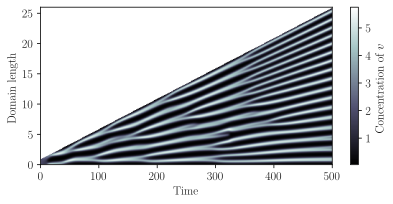

In [9]:
# Model specs
kinetic_scheme = 'schnakenberg'
a, b = 0.01, 2
kinetic_params = (a, b)

Du = 1
Dv = Du / 100
gamma0 = 1

rho = 0.05
zeta = 26
delta = 0.01
growth_type = 'linear'

# Sim specs
sim_time = 500
t_steps_per_unit = 50
num_space_points = 150

# Initial condition construction, disturbance from homogeneous steady state
initial_u = b / ((a + b)**2)  # Initial average concentration of u
initial_v = a + b             # Initial average concentration of v
noise_level = 1               # Noise level for initial condition perturbations

u0 = np.ones(num_space_points) * initial_u + noise_level * np.random.randn(num_space_points)
v0 = np.ones(num_space_points) * initial_v + 0           * np.random.randn(num_space_points) # MAYBE NO NOISE
ics_tuple = (u0, v0)

# Plot specs
no_plot_points = 1300

# Plot options
figsize = (5.9, 3)
plot = 'v'
savefig = True

solve_plot(kinetic_scheme, growth_type, kinetic_params, Du, Dv, gamma0,
          num_space_points, ics_tuple, rho, zeta, delta, sim_time,
          t_steps_per_unit, no_plot_points, figsize, plot, savefig)